In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='WARNING')

## The contact binary Bundle

A contact binary Bundle is created by passing **contact_binary=True** to the default binary bundle.

In [2]:
cb = phoebe.default_binary(contact_binary = True)

The main difference between the detached and contact binary Bundles is in the *hierarchy* of the system. In addition to the two star components, contact binaries have an **envelope component** as well.

In [3]:
print(cb.hierarchy)


    orbit:binary
    
        star:primary
        star:secondary
        envelope:contact_envelope
    



The parameters of the system are distributed between the star and envelope components. The stellar parameters, like mass, radius, temperature, etc. are attached to the primary and secondary star components. The overall (shared) parameters, like potential, fillout factor, metallicity, etc. are attached to the envelope component. For a full list of parameters associated with each component, we can filter on them:

In [4]:
print(cb.filter(context='component', kind='star', component='primary'))

ParameterSet: 19 parameters
        requiv@primary@component: 1.5 solRad
*   requiv_max@primary@component: 1.6724563973 solRad
*   requiv_min@primary@component: 1.2725418569 solRad
          teff@primary@component: 6000.0 K
*         logg@primary@component: 4.0897361581
       syncpar@primary@component: 1.0
*       period@primary@component: 0.5 d
*         freq@primary@component: 12.56637 rad / d
         pitch@primary@component: 0.0 deg
           yaw@primary@component: 0.0 deg
          incl@primary@component: 90.0 deg
       long_an@primary@component: 0.0 deg
     gravb_bol@primary@component: 0.32
  irrad_frac_refl_bol@primary...: 0.6
* irrad_frac_lost_bol@primary...: 0.4
   ld_func_bol@primary@component: logarithmic
  ld_coeffs_bol@primary@compo...: [0.5 0.5]
*         mass@primary@component: 1.0089067995 solMass
*          sma@primary@component: 1.675 solRad


In [5]:
print(cb.filter(context='component', kind='star', component='secondary'))

ParameterSet: 19 parameters
*     requiv@secondary@component: 1.5 solRad
* requiv_max@secondary@component: 1.6724563973 solRad
* requiv_min@secondary@component: 1.2725418569 solRad
        teff@secondary@component: 6000.0 K
*       logg@secondary@component: 4.0897361581
     syncpar@secondary@component: 1.0
*     period@secondary@component: 0.5 d
*       freq@secondary@component: 12.56637 rad / d
       pitch@secondary@component: 0.0 deg
         yaw@secondary@component: 0.0 deg
        incl@secondary@component: 90.0 deg
     long_an@secondary@component: 0.0 deg
   gravb_bol@secondary@component: 0.32
  irrad_frac_refl_bol@seconda...: 0.6
* irrad_frac_lost_bol@seconda...: 0.4
  ld_func_bol@secondary@compo...: logarithmic
  ld_coeffs_bol@secondary@com...: [0.5 0.5]
*       mass@secondary@component: 1.0089067995 solMass
*        sma@secondary@component: 1.675 solRad


As before, the parameters marked with an asterix (\*) are constrained by other parameters. If we compare the primary and secondary, we notice that the equivalent radius (requiv) of the primary is a free parameter, while the secondary requiv is constrained by the envelope potential, mass ratio and semi-major axis of the system:

In [6]:
print(cb['requiv@secondary@constraint'])

Constrains (qualifier): requiv
Expression in solar units (value): pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
Current Result (result): 1.5000000000224998 solRad


This is one way in which the implementation of contact binaries in PHOEBE differes from the detached systems. The relative sizes of the two stars are "linked" through the shared envelope potential and mass ratio of the system, thus only the primary requiv needs to be provided by the user.

Let's filter on the envelope component:

In [7]:
print(cb.filter(context='component', kind='envelope'))

ParameterSet: 5 parameters
  abun@contact_envelope@compo...: 0.0
* fillout_factor@contact_enve...: 0.6417897081
* pot@contact_envelope@component: 3.4013774072
* pot_min@contact_envelope@co...: 3.2067962241
* pot_max@contact_envelope@co...: 3.75


As you can see, all of the envelope parameters except the abundance are constrained. Let's check which parameters constrain the fillout factor and potential:

In [8]:
print(cb['fillout_factor@contact_envelope@constraint'])

Constrains (qualifier): fillout_factor
Expression in solar units (value): pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
Current Result (result): 0.6417897081320958


In [9]:
print(cb['pot@contact_envelope@constraint'])

Constrains (qualifier): pot
Expression in solar units (value): requiv_to_pot_contact({requiv@primary@component}, {q@binary@component}, {sma@binary@component}, 1)
Current Result (result): 3.4013774072298766


From the above two calls we can see that the fillout factor is constrained by the potential of the envelope, which is in turn constrained by the primary equivalent radius. This allows for a lot of freedom in terms of which parameters are chosen to describe a contact binary system - if we're comparing to evolutionary simulations, we probably know the values of the equivalent radii or the fillout factor; if we have a phoebe-legacy model, we know the value of the potential instead. This allows for easy and accurate comparison with other codes and models.

### ** Note on fillout factor

There are several different definitions of the fillout factor used in the literature. In Phoebe we use the following:
\begin{equation}
FF = \frac{\Omega - \Omega_{L1}}{\Omega_{L23} - \Omega_{L1}}
\end{equation}
where $\Omega$ is the envelope potential, and $\Omega_{L1}$ and $\Omega_{L23}$ are the inner and outer critical potentials, respectively. Thus, the fillout factor is 0 at the inner and 1 at the outer critical potential.

### Exercise

Flip the constraints so that the fillout factor is an adjustable parameter and the primary requiv is a constrained one.

## Meshes, datasets, compute

Everything else works the same as for detached systems, with certain contact binary - related precautions that need to be taken into account. We'll get to them in this section.

Let's add a mesh and light curve dataset, compute and plot the model.

In [13]:
cb.add_dataset('mesh', times=[0.125], dataset='mesh01', columns=['teffs'], overwrite=True)
cb.add_dataset('lc', times=np.linspace(0.,0.5,50), dataset='lc01', overwrite=True)

Tue, 02 Jul 2019 10:20 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.


<ParameterSet: 19 parameters | contexts: compute, constraint, dataset>

In [14]:
cb.run_compute()

<ParameterSet: 14 parameters | kinds: mesh, lc>

Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color
Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


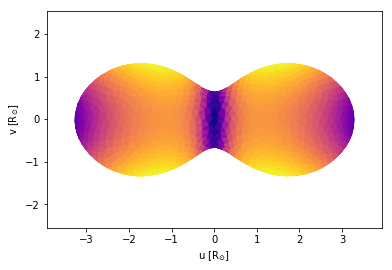

In [15]:
axs, artists = cb.plot('mesh01', fc='teffs', ec='face', fcmap='plasma', show=True)

*Fun, but impractical* - since the mesh is still assigned to each component separately, we can also plot just a half of the envelope that pertains to one star:

Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


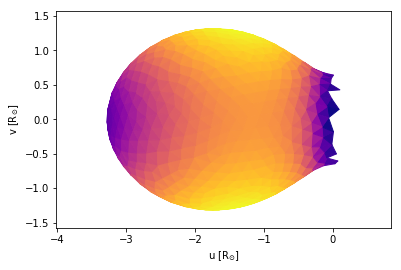

In [16]:
axs, artists = cb.plot('mesh01@primary', fc='teffs', ec='face', fcmap='plasma', show=True)

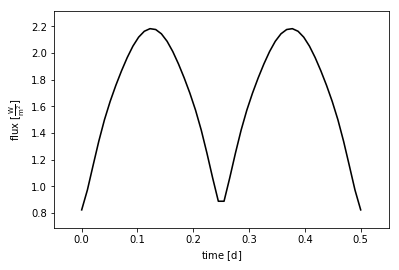

In [17]:
axs, artists = cb.plot('lc01', show=True)

The way the surface temperature values are assigned is also component-dependent, so the two "halves" of the envelope are treated like single, separate stars that are separated in the neck by an artifical boundary that the code introduces. This treatment was first implemented in W-D and we are working towards a better, more physical solution.

To illustrate the component splitting in terms of temperature distribution, let's change one of the effective temperatures and the recommended values of gravity brightening and reflection coefficient for that temperature:

In [18]:
cb.set_value('teff', component='primary', value=9000.)

Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING 'primary' probably has a radiative atm (teff=9000K>8000K), for which gravb_bol=1.00 might be a better approx than gravb_bol=0.32.


In [19]:
cb.set_value('gravb_bol', component='primary', value=1.)
cb.set_value('irrad_frac_refl_bol', component='primary', value=1.)

Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING 'primary' probably has a radiative atm (teff=9000K>8000K), for which irrad_frac_refl_bol=1.00 might be a better approx than irrad_frac_refl_bol=0.60.


In [20]:
cb.run_compute()

Tue, 02 Jul 2019 10:20 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 14 parameters | kinds: mesh, lc>

Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING assuming you meant 'fc' instead of 'facecolor'
Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color
Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING assuming you meant 'fc' instead of 'facecolor'
Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


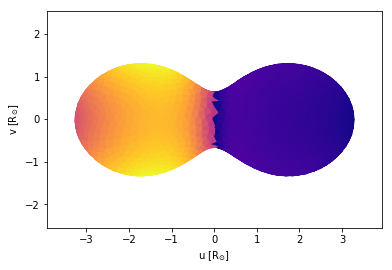

In [21]:
axs, artists = cb.plot('mesh01', facecolor='teffs', ec='face', fcmap='plasma', show=True)

### Failed meshes

Because the mesh of a contact binary envelope is not convex, certain combinations of parameters (i.e. very low or very high fillout factor, very low mass ratio) can lead to failing or weird marching meshes.

In [22]:
cb['q'] = 0.1
cb['fillout_factor'] = 0.05

Tue, 02 Jul 2019 10:20 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING constraints ['requiv@secondary@star@constraint'] failed to run.  Address errors and try again.  Call run_failed_constraints to see the tracebacks.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Tue, 02 Jul 2019 10:20 PARAMETERS   WARNING constraints ['requiv@secondary@star@constraint'] failed to run.  Address errors and try again.  Call run_failed_constraints to see the tracebacks.  If not addressed, this warning will continue to be rais

In [23]:
cb.run_compute()

Mon, 01 Jul 2019 21:21 BUNDLE       WARNING overwriting model: latest


TypeError: Projections are failing!

There is no direct solution to an issue like this one - in cases of small fillout factors it might work to use a detached system close to fillout instead or increase the value of the fillout factor until a mesh can be created successfully. In some cases it's sufficient to increase the number of triangles. For example:

In [23]:
cb['q'] = 0.1
cb['fillout_factor'] = 0.1

In [24]:
cb.run_compute() # will fail with an obscure error

Tue, 02 Jul 2019 10:21 BUNDLE       WARNING overwriting model: latest


KeyError: 135

In [25]:
cb.run_compute(ntriangles=5000) # will compute successfully

<ParameterSet: 14 parameters | kinds: mesh, lc>

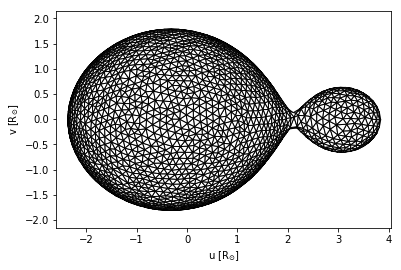

In [26]:
ax, artists = cb.plot('mesh01', show=True)

*Rule of thumb: if increasing the number of triangles to 5000-10000 doesn't work, Phoebe can't model the desired system with a marching mesh.*

## Spots

Let's go back to our previous, easy to model system first, and compute a model without a spot:

In [28]:
cb['q'] = 1.
cb['fillout_factor'] = 0.5
cb.run_compute(irrad_method='none')

Mon, 01 Jul 2019 21:29 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING constraints ['requiv@secondary@star@constraint'] failed to run.  Address errors and try again.  Call run_failed_constraints to see the tracebacks.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING constraints ['requiv@secondary@star@constraint'] failed to run.  Address errors and try again.  Call run_failed_constraints to see the tracebacks.  If not addressed, this warning will continue to be r

<ParameterSet: 14 parameters | kinds: lc, mesh>

Let's add a spot to the primary component in our binary. Note that if you attempt to attach to the 'contact_envelope' component, an error will be raised. Spots can only be attached to star components.

In [29]:
cb.add_feature('spot', component='primary', feature='spot01', relteff=0.5, radius=20, colat=90, long=-45, overwrite=True)

Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING wrapping value of long to 315.0 deg


<ParameterSet: 4 parameters | qualifiers: colat, relteff, radius, long>

In [30]:
cb.run_compute(irrad_method='none', model='with_spot', overwrite=True)

<ParameterSet: 14 parameters | kinds: lc, mesh>

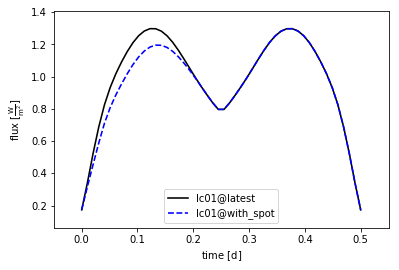

In [31]:
afig, mplfig = cb.plot('lc', show=True, legend=True)

Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


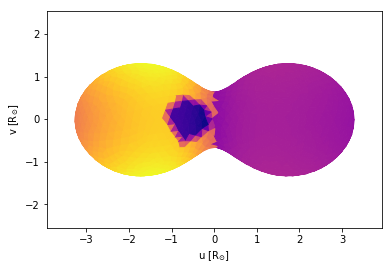

In [32]:
afig, mplfig = cb.plot('mesh01@with_spot', fc='teffs', ec='face', fcmap='plasma', show=True)

### Spots near the neck

Since the spots are still defined with the coordinate system of the individual star components, this can result in spots that are distorted and even "cropped" at the neck. Furthermore, spots with long=0 could be completely "hidden" by the neck or result in a ring around the neck.

If we set the longitude of the spot closer to the neck, we'll see it get cropped by the boundary between the two components. If we need a spot that crosses between the two "halves" of the contact, we'd have to add separate spots to each component, with each getting cropped at the boundary.

Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING wrapping value of long to 330.0 deg
Mon, 01 Jul 2019 21:29 BUNDLE       WARNING overwriting model: with_spot
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


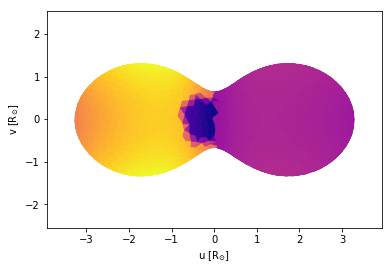

In [33]:
cb.set_value('long', value=-30)
cb.run_compute(irrad_method='none', model='with_spot', overwrite=True)
afig, mplfig = cb.plot('mesh01@with_spot', fc='teffs', ec='face', fcmap='plasma', show=True)

If we set long to zero, the spot completely disappears (as there is nowhere in the neck that is still on the surface.

Mon, 01 Jul 2019 21:29 BUNDLE       WARNING overwriting model: with_spot
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


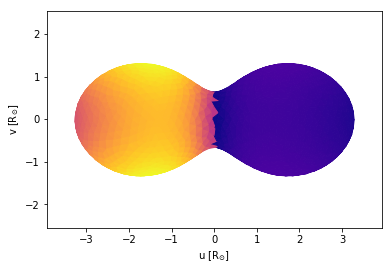

In [34]:
cb.set_value('long', value=0.0)
cb.run_compute(irrad_method='none', model='with_spot', overwrite=True)
afig, mplfig = cb.plot('mesh01@with_spot', fc='teffs', ec='face', fcmap='plasma', show=True)

But if we increase the radius large enough, we'll get a ring.

Mon, 01 Jul 2019 21:29 BUNDLE       WARNING overwriting model: with_spot
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color
Mon, 01 Jul 2019 21:29 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.125000, assuming named color


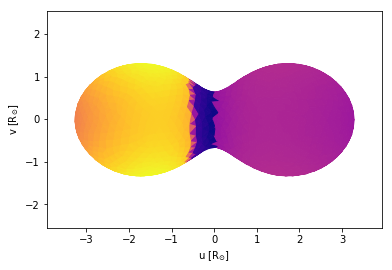

In [35]:
cb.set_value('radius', value=40)
cb.run_compute(irrad_method='none', model='with_spot', overwrite=True)
afig, mplfig = cb.plot('mesh01@with_spot', fc='teffs', ec='face', fcmap='plasma', show=True)

### Exercise

Try to put a spot directly on the neck by combining two spots - one on the primary and one on the secondary.